Work in progress - Note to myself, still to do:
    - test error calculation on X_train vs full X
    - implement a better way for feature reduction (Lasso or backward approach from ML-Statistics book)
    - play around with Ridge / Lasso / Elastic Net Option
    
    

- alpha : {float, array-like}, shape (n_targets). Regularization strength; must be a positive float. Regularization improves the conditioning of the problem and reduces the variance of the estimates. Larger values specify stronger regularization. Alpha corresponds to C^-1 in other linear models such as LogisticRegression or LinearSVC. If an array is passed, penalties are assumed to be specific to the targets. Hence they must correspond in number.
- fit_intercept : boolean Whether to calculate the intercept for this model. If set to false, no intercept will be used in calculations (e.g. data is expected to be already centered).
- normalize : boolean, optional, default False This parameter is ignored when fit_intercept is set to False. If True, the regressors X will be normalized before regression by subtracting the mean and dividing by the l2-norm. If you wish to standardize, please use sklearn.preprocessing.StandardScaler before calling fit on an estimator with normalize=False.

The preprocessing is not sophisticated at all, but 
- numerical data is normalized, 
- NaN are removed, 
- and there is One-Hot-Encoding for the categorical data.

**Note:** If the data is already centered and you want `fit_intercept = False`, then normalization will not be applied. See [here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) for more info, and see Bycicle notebook for an example with centered data.

# Demo of LinRegModel Class and it's Methods

### Load libraries and data

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import resample  # for error calculation of feature weights

from helpers import EDA_functions, cleaning_functions
import LinRegModel

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

# display all columns in df
from IPython.display import display
pd.options.display.max_columns = None

In [2]:
housing = pd.read_csv('../data/housing.csv')

### Check dataframe structure

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing.sample(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
4968,-118.28,34.01,50.0,2601.0,794.0,3080.0,770.0,1.8656,122900.0,<1H OCEAN
7145,-118.13,34.02,43.0,396.0,91.0,261.0,73.0,2.9044,172900.0,<1H OCEAN
15376,-117.25,33.37,8.0,1755.0,530.0,1687.0,511.0,1.9950,146900.0,<1H OCEAN


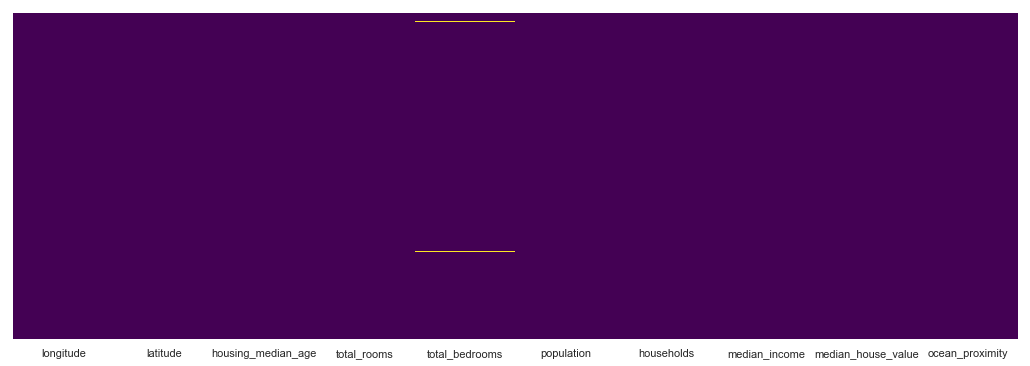

In [5]:
cleaning_functions.plot_NaN(housing)

In [6]:
cleaning_functions.list_NaN(housing)

Number of NaN per column:
total_bedrooms: 207 (0.01%)


### Function for one-step LinReg modelling

Function for cleaning, preparing, fitting and evaluating LinReg model:

**Attention**:
- All columns with dtype object and category will be one-hot-encoded. Make shure they all have categorical character
- All NaN in numerical cols will be imputed with mean
- All NaN in non-numerical cols are mixed in zero category, for own column change 'dummy_na' parameter)

In [7]:
model = LinearRegression(normalize=True)

linReg_simple = LinRegModel.LinRegModel(housing, 'median_house_value', model)

In [8]:
# linReg_simple.go_quickDirty()

In [9]:
linReg_simple

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

**NOTE**
- RMSE has to be calculated from MSE. Both are sensitive to outliers. If you have lot's of outliers MAE might be preferable.
- R2-score can be problematic, there is also an adjusted R2-score to consider.

# Regularization, Feature Selection and Feature Interpretation

According to a very interesting [blog post on "Diving Into Data"](http://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/) regularized linear models are a powerful tool for feature interpretation and selection if you are aware of the following:
- _L1 / Lasso_ produces sparse solutions and as such is very useful _selecting a strong subset of features_ for improving model performance. But it is not stable enough to provide a trustworthy interpretation of feature importance as even small changes to the data can massively change the coefficients.
- _L2 / Ridge_ on the other hand can be used for _data interpretation_ due to its stability and the fact that useful features tend to have non-zero coefficients. 

__Why__: Generally in linear regression only the _residual sum of squares (RSS)_ is minimized, whereas in ridge and lasso regression, a _penalty is applied on coefficient values_ with the tuning parameter lambda (lambda=0 no penalty effect, lambda=large pushes coefficients towards / to zero).

- _L2 / Ridge_ shrinks the weights according to their importance, but does not set them exactly to zero in order to eliminate unneccessary predictors from models. It will always include all the predictors. _Models from Ridge provide accuracy but are hard to interpret when the numer of predictors is large._
- _L1 / Lasso_ on the other hand sets the weights of the unnecessary variables to zero and so eliminates them creating compact models that are easier to interpret. _Models from lasso are very much like subset selection_. The cost is less robustness.

Further reading on regularization, 'Pyhton Data Science Handbook', p. 396f.


### Feature Importance / Coefficients
***Attention: They may be completely different from those of an optimized model! See below.***

The default penalty on coefficients using linear regression in sklearn is a ridge (also known as an L2) penalty.  Because of this penalty, and because all the variables were normalized, we can look at the size of the coefficients in the model as an indication of the impact of each variable on the target variable. The larger the coefficient, the larger the expected impact. 

Run function:

## Reduce Overfitting / Features and Optimize Model

Define function for finding an optimized model (with less overfitting thanks to a reduction in features).

**Note:**
- The decision on witch features are kept is depending on NaN, this is not good. I should be able to do better

In [ ]:
def optimizeLinModel(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X: pandas dataframe, X matrix
    y: pandas dataframe, response variable
    cutoffs: list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size: float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state: int, default 42, controls random state for train_test_split
    plot: boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test: list of floats of r2 scores on the test data
    r2_scores_train: list of floats of r2 scores on the train data
    opt_model: model object from sklearn
    X_train, X_test, y_train, y_test: output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    
    for cutoff in cutoffs:
        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])
        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)
        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)
        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc='lower right')
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    opt_model = LinearRegression(normalize=True)
    opt_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, opt_model, X_train, X_test, y_train, y_test

In [ ]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]

#Run this cell to pass your X and y to the model for testing
r2_scores_test, r2_scores_train, opt_model, X_train, X_test, y_train, y_test = optimizeLinModel(X, y, cutoffs)

Stats for optimized model:

In [ ]:
print(X_train.shape[1]) #Number of features
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2

## Feature Importance / Coefficients - for optimized Model

In [ ]:
coef_df = coef_weights(opt_model, X_train)
coef_df.head(20)

***